In [7]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch import nn

In [4]:
##### define transform #####

# toTensor() converts PIL images / np.ndarray to tensor 
# (H * W * C) to (C * H * W) |  [0, 255] to [0.0, 1.0]

# Normalize() transforms pixel intensities from [0, 1] to [-1, 1]

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# processing 4 images at once. *adjustable*
batch_size = 4

# set trainset: loading CIFAR-10, apply previously defined transform function
trainset = torchvision.datasets.CIFAR10(root = './data', 
                                        train = True, 
                                        download = True, 
                                        transform = transform)

# set trainloader: put training dataset to DataLoader
trainloader = torch.utils.data.DataLoader(trainset, 
                                           batch_size = batch_size,
                                           shuffle = True, 
                                           num_workers = 2)

# set testset and loader: same as earlier
testset = torchvision.datasets.CIFAR10(root = './data',
                                       train = False,
                                       download = True,
                                       transform = transform)
testloader = torch.utils.data.DataLoader(testset, 
                                          batch_size = batch_size,
                                          shuffle = True, 
                                          num_workers = 2)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


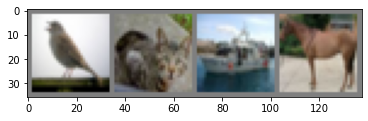

bird  cat   ship  horse


In [11]:
# this is pytorch code on image display

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
# generator
# latent vector (random noise) -> CIFAR-10 like image
class Generator(nn.Module):
    def __init__(self, input_size):
        super(Generator, self).__init__()
        
        # reshape
        # 100 -> 1024 * 4 * 4
        self.linear = nn.Linear(input_size, 1024 * 4 * 4)
        
        self.main = nn.Sequential(
            # first conv layer: (num_input, num_output, 4x4 kernel)
            nn.ConvTranspose2d(1024, 512, 4, stride = 2, padding = 1, bias = False),
            # batchnorm size should match the ouput of prev layer
            nn.BatchNorm2d(512),
            # ReLU true such that operation is done in place
            nn.ReLU(True),
            
            # 512 * 8 * 8 -> 256 * 16 * 16
            nn.ConvTranspose2d(512, 256, 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            #258 * 16 * 16 -> 128 * 32 * 32
            nn.ConvTranspose2d(256, 128, 4, stride = 2, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # 128 * 32 * 32 -> 3 * 64 * 64
            nn.ConvTranspose2d(128, 3, 4, stride = 2, padding = 1, bias = False),
            nn.Tanh()
        )
    def forward(self, input):
        input = self.linear(input)
        input = input.view(input.size(0), 1024, 4, 4)
        return self.main(input)

In [10]:
# discriminator
# image -> scalar probability of absurdity (probability of image being real)
class Discriminator(nn.Module):
    def __init__(self, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is 3 x 64 x 64
            nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # output is a single value (is the image real or fake)
        )

    def forward(self, input):
        return self.main(input)